# Example of global pipeline using XTRAINS dataset

OntoClassifier using a yoloV8 model that has been trained to recognize types of wagon on images. 

Link to the XTRAINS dataset: [https://bitbucket.org/xtrains/dataset/src/master/](https://bitbucket.org/xtrains/dataset/src/master/)

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from ultralytics import YOLO

from ontoclassifier import *

from PIL import Image
import matplotlib.pyplot as plt

## Loading ontology

In [2]:
onto_filename = "data/xtrains_ontology.owl"
xtrains = owlready2.get_ontology(onto_filename).load()
owlready2.sync_reasoner()

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /Users/gregorybourguin/opt/miniconda3/envs/pytorch_m1/lib/python3.10/site-packages/owlready2/hermit:/Users/gregorybourguin/opt/miniconda3/envs/pytorch_m1/lib/python3.10/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/0v/n6jy7sss685d7r18q2cr_g880000gn/T/tmpp1g9zyd2
* Owlready2 * HermiT took 0.5289928913116455 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [3]:
print(list(xtrains.Train.descendants()))

[xtrains_ontology.WarTrain, xtrains_ontology.TypeC, xtrains_ontology.LongFreightTrain, xtrains_ontology.PassengerTrain, xtrains_ontology.RuralTrain, xtrains_ontology.LongTrain, xtrains_ontology.TypeB, xtrains_ontology.MixedTrain, xtrains_ontology.EmptyTrain, xtrains_ontology.FreightTrain, xtrains_ontology.Train, xtrains_ontology.TypeA]


## Global pipeline with Yolov8 Wrapper

In [4]:
# Selecting targeted classes
target_classes = xtrains.Train.descendants()

# otherwise choose only some classes:
# target_classes = [
#     xtrains.LongTrain,
#     xtrains.EmptyTrain,
#     xtrains.FreightTrain,
#     xtrains.PassengerTrain,
# ]

In [5]:
# Loading pretrained YoloV8 object model detecting biomarkers
yolo_model = YOLO('data/xtrains-yolov8.pt')
yolo_model.names

{0: 'Loc',
 1: 'ELR',
 2: 'EL',
 3: 'ER',
 4: 'E',
 5: 'PLR',
 6: 'PL',
 7: 'PR',
 8: 'P',
 9: 'FLR',
 10: 'FL',
 11: 'FR',
 12: 'F'}

In [6]:
# Creating Property Wrappers
has_feature = OntoFeature(xtrains.has)
has_property_wrapper = YoloV8PropertyWrapper(
    yolo_model,
    has_feature,
    {   # map yolo detected classes to ontology classes 
        0: ["Locomotive"],
        1: ["EmptyWagon", "LongWagon", "ReinforcedCar"],
        2: ["EmptyWagon", "LongWagon"],
        3: ["EmptyWagon", "ReinforcedCar"],
        4: ["EmptyWagon"],
        5: ["PassengerCar", "LongWagon", "ReinforcedCar"],
        6: ["PassengerCar", "LongWagon"],
        7: ["PassengerCar", "ReinforcedCar"],
        8: ["PassengerCar"],
        9: ["FreightWagon", "LongWagon", "ReinforcedCar"],
        10: ["FreightWagon", "LongWagon"],
        11: ["FreightWagon", "ReinforcedCar"],
        12: ["FreightWagon"]
    },
)

In [7]:
# Creating the Ontological Feature Extractor
fe_yolo = Yolov8FeaturesExtractor([has_property_wrapper])
ontological_extractor = OntologicalExtractor({0: [fe_yolo]})

In [8]:
# Creating the OntoClassifier instance
onto_classifier = OntoClassifier(xtrains, target_classes, ontological_extractor)

In [9]:
# Creating the hybrid AI pipeline
pipeline = torch.nn.Sequential(
        ontological_extractor,
        onto_classifier
)

In [10]:
onto_classifier.getTargettedClassesEncoder().classes_

array(['http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#EmptyTrain', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#FreightTrain', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#LongFreightTrain',
       'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#LongTrain', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#MixedTrain', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#PassengerTrain',
       'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#RuralTrain', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#Train', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#TypeA', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#TypeB',
       'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#TypeC', 'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#WarTrain'], dtype=object)

## Inference

In [11]:
from torchvision.io import read_image, ImageReadMode

images = ['data/xtrains-0082.png', 'data/xtrains-0123.png']

img_tensors = []
for img in images:
    img_tensors.append(read_image(img, ImageReadMode.RGB).float())

inputs = torch.stack(img_tensors)

In [12]:
# Classification results
results = pipeline(inputs)
labels = onto_classifier.getTargettedClassesEncoder().inverse_transform(results)
pprint(labels)

[('http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#FreightTrain',
  'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#LongFreightTrain',
  'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#LongTrain',
  'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#Train',
  'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#TypeB'),
 ('http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#LongTrain',
  'http://www.semanticweb.org/lewandowski/ontologies/2023/2/xtrains#Train')]


In [13]:
# Focusing on a specific image
num = 0

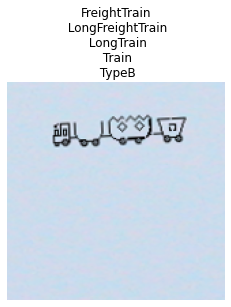

In [14]:
img = Image.open(images[num])

classes = [xtrains.search(iri=iri)[0] for iri in labels[num]]
names = [c.name for c in classes]

title = str(names).replace('[', '').replace(']', '').replace('\'', '').replace(',', '\n')
plt.title(title)
plt.axis('off')
plt.imshow(img)

## Explain results

In [15]:
# Instanciating a simple explainer using the OntoClassifier features
explainer = OntologicalExtractorExplainer(ontological_extractor, onto_classifier)

This is a LongFreightTrain because : 
  This is a Train because : 
    has SOME Locomotive or Wagon is True 
      found EmptyWagon, FreightWagon, [FreightWagon & LongWagon], Locomotive
  This is a FreightTrain because : 
    This is a Train because : 
      has SOME Locomotive or Wagon is True 
        found EmptyWagon, FreightWagon, [FreightWagon & LongWagon], Locomotive
    has MIN 2 FreightWagon is True 
      found 2 FreightWagon
  This is a LongTrain because : 
    has MIN 3 Wagon is True 
      found EmptyWagon, FreightWagon, [FreightWagon & LongWagon]



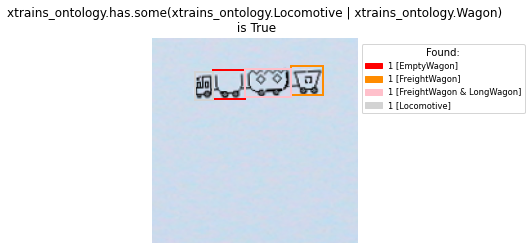

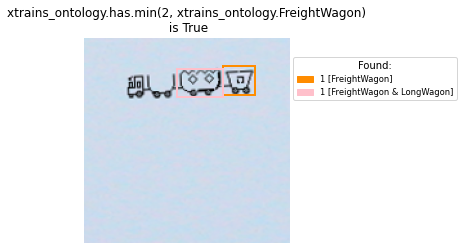

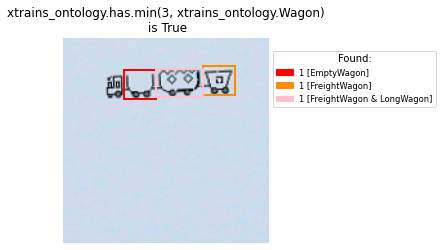

In [16]:
one_input = torch.stack([img_tensors[0]])

# Explaining why a given image is (NOT ?) classified as a LongFreightTrain
explainer.explain(
    xtrains.LongFreightTrain, 
    one_input
    )


This is NOT a EmptyTrain because : 
  has ONLY EmptyWagon or Locomotive is False 
    found [FreightWagon & LongWagon]



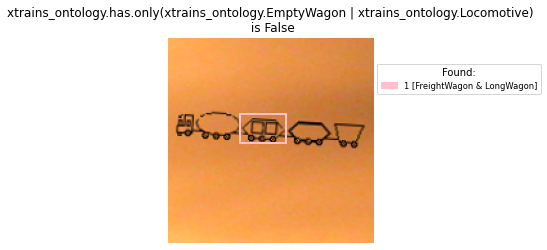

In [17]:
# Explaining why a given image is (NOT ?) classified as a EmptyTrain
one_input = torch.stack([img_tensors[1]])

explainer.explain(
    xtrains.EmptyTrain, 
    one_input
    )
